In [1]:
# written in python3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio


def my_transform(data, label, degree, FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

# functions for reading data

In [2]:
# read energy, rw, bias, rmsd data from location
def read_data(name):
#     name="tr872"
    name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB","VTotal"]

    # you probably want to change the location below
#     location = f"/Users/weilu/Research/server/sep_2018/03_week/02_week/{name}/"
    location = f"/Users/weilu/Research/server/dec_2018/structure_selection_2/{name}/"
    RMSD = pd.read_table(location+"rmsd.xvg", names=["i", "RMSD"], sep="\s+")
    bias = pd.read_table(location+"bias.log", names=["i", "biasQ", "bias"], sep="\s+").drop("i", axis=1)
    awsem = pd.read_table(location+"awsem.log", names=name_list)
    rw = pd.read_table(location+"rwplusScore.txt", names=["i", "Rw"], sep="\s+").drop("i", axis=1)
    qw = pd.read_table(location+"Qw.out", names=["i", "Qw"], sep="\s+", comment="#").drop("i", axis=1)
    # pc location
#     location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
#     location = f"/Users/weilu/Research/server/oct_2018/01_week/{name}/"
    pc = pd.read_table(location+"pcarmsd_scaled.txt", names=["i", "pc", "pc2"], sep="\s+", comment="#").drop("i", axis=1)
    raw_data = pd.concat([RMSD, rw, bias, qw, awsem, pc], axis=1)
    return raw_data.assign(name=name).reset_index().rename(columns={"index":"folder"})

def choose_top(data,col="RMSD", n=5, ascending=True):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='dense')<=n)

# read the pmf, rc. 
# def read_data_2(name):
# #     name = "tr894"
# #     location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
# #     location = f"/Users/weilu/Research/server/oct_2018/01_week/{name}/"
#     location = f"/Users/weilu/Research/server/dec_2018/structure_selection/{name}/"
#     rw = pd.read_table(location+"rc_rwplus", names=["pc","rw"], sep="\s+")
#     rmsd = pd.read_table(location+"rc_rmsdlowerBound", names=["pc", "rmsd"], sep="\s+")
#     awsem = pd.read_table(location+"rc_awsemEne", names=["pc", "awsem"], sep="\s+")
#     qw = pd.read_table(location+"rc_QwhigherBound", names=["pc", "qw"], sep="\s+")
#     freeE = pd.read_table(location+"pmf3000"
#                           , names=["pc", "f", "remove1", "remove2"], sep="\s+").drop(["remove1", "remove2"], axis=1)
#     raw_data = freeE.merge(rw, on="pc").merge(awsem, on="pc").merge(qw, on="pc").merge(rmsd, on="pc").assign(name=name)
#     return raw_data

def read_data_2(name):
#     name = "tr894"
#     location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
#     location = f"/Users/weilu/Research/server/oct_2018/01_week/{name}/"
    location = f"/Users/weilu/Research/server/dec_2018/structure_selection_2/{name}/"
    rw = pd.read_table(location+"rc_rwplus", names=["pc","rw"], sep="\s+")
    rmsd = pd.read_table(location+"rc_rmsdlowerBound", names=["pc", "rmsd"], sep="\s+")
#     awsem = pd.read_table(location+"rc_awsemEne", names=["pc", "awsem"], sep="\s+")
#     qw = pd.read_table(location+"rc_QwhigherBound", names=["pc", "qw"], sep="\s+")
    freeE = pd.read_table(location+"pmf3000"
                          , names=["pc", "f", "remove1", "remove2"], sep="\s+").drop(["remove1", "remove2"], axis=1)
    raw_data = freeE.merge(rw, on="pc").merge(rmsd, on="pc").assign(name=name)
    return raw_data


# train based on free energy, rw and awsem.

In [3]:
# folder_list = ["tr894", "tr882", "tr594", "tr898", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
folder_list = ["tr884-halfDIHE", "tr872-halfDIHE", "tr948-halfDIHE", "tr898", "tr947", "tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr884-halfDIHE", "tr872-halfDIHE", "tr898", "tr947", "tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]


# folder_list = [ "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]
# "tr877","tr884", "tr922"
# "tr869"
# folder_list = ["tr894"]
# read all data

# tr884-halfDIHE
# tr872-halfDIHE
# tr948-halfDIHE
data_list = []
for name in folder_list:
    tmp = read_data_2(name)
    data_list.append(tmp)
raw_data_all = pd.concat(data_list)
n = 1
raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(choose_top, n=n, col="rmsd").reset_index(drop=True)


# train_name_list = ["tr872", "tr885", "tr948"]
# train_name_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]

# train_name_list = ["tr870"]
# train_name_list = ["tr891"]
# train_name_list = ["tr882"]
# train_name_list = ["tr894"]
# train_name_list = ["tr872"]
# train_name_list = ["tr869"]
# train_name_list = ["tr884"]
# train_name_list = ["tr866", "tr884"]
# train_name_list = ["tr870", "tr872"]
# train_name_list = ["tr866", "tr947"]
# train_name_list = ["tr872"]
# train_name_list = ["tr884", "tr872"]
train_name_list = ["tr866"]
# train_name_list = ["tr947"]
# select for training.
raw_data = raw_data_all.reset_index(drop=True).query(f'name in {train_name_list}')

In [4]:

# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = ["f",
    'rw',
     'awsem',
#     'RMSD', # test
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "rmsd"
# LABEL = "qw"
DEGREE = 1

def pred_from_raw(a, clf):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prediceted_rmsd= clf.predict(test_set)
    return a.assign(prediceted_rmsd=prediceted_rmsd)

def assign_lowest_f(a):
    return a.assign(lowest_f=a["f"].sort_values().iloc[0])


In [5]:
raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(assign_lowest_f).reset_index(drop=True)

In [6]:
# # data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# # data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
# data = np.concatenate(raw_data.groupby('name').apply(my_transform, 
#                                                      label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
# train_y = data[:,-1]
# train_set = data[:,:-1]
# from sklearn import svm
# # clf = svm.SVC(probability=True)
# clf = LinearRegression()
# clf.fit(train_set, train_y)
# y_pred_svm = clf.predict(train_set)

# raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(pred_from_raw, clf).reset_index(drop=True)
# # raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(assign_lowest_f).reset_index(drop=True)



# picked_n = 1
# best = raw_data_all.groupby("name").apply(choose_top, col="rmsd"
#                                             , n=picked_n, ascending=True).reset_index(drop=True).query("chosen==True")
# picked = raw_data_all.groupby("name").apply(choose_top, col="prediceted_rmsd"
#                                             , n=picked_n, ascending=True).reset_index(drop=True).query("chosen==True")
# # init = raw_data_all.query("i == 0.0")
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])

# picked_keep = picked.copy()

In [7]:
from scipy.interpolate import interp1d
f_dic = {}
for name in folder_list:
    a = raw_data_all.query(f"name == '{name}'")
#     print(name ,a.shape)
    x = a["pc"].values
    y = a["f"].values
    f_dic[name] = interp1d(x, y, fill_value="extrapolate")


In [8]:
# g = sns.FacetGrid(raw_data_all, col="name", col_wrap=4)
# g = g.map(plt.plot, "pc", "f")
# plt.ylim([0,1])

In [9]:
# g = sns.FacetGrid(raw_data_all, col="name", col_wrap=4)
# g = g.map(plt.plot, "pc", "f")
# g = g.map(plt.plot, "pc", "prediceted_rmsd")

In [10]:
# raw_data_all.query("name == 'tr594'").plot("pc", "f")

In [11]:
# g = sns.FacetGrid(raw_data_all, col="name", col_wrap=4)
# g = g.map(plt.plot, "pc", "rmsd")
# plt.ylim([0,1])

# used picked_keep as to filter the compelete data and select again

In [12]:
f_dic["tr594"](raw_data_all["pc"]).shape

(608,)

In [13]:
def choose_top(data,col="RMSD", n=5, ascending=True):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)


# WIDTH = 100
# WIDTH = 0.1
# WIDTH = 1
# WIDTH = 0.2
# def with_in_range(data, width=WIDTH):
#     return data.assign(inrange= (data["pc"] < (data["pc_center"]+width)) & (data["pc"] > (data["pc_center"]-width)))

def with_in_range(data, width=5):
    name = data["name"].iloc[0]
    return data.assign(inrange= (0 < (f_dic[name](data["pc"]))) & ((f_dic[name](data["pc"])) < width))

In [14]:
# folder_list = ["tr898", "tr869", "tr947", "tr894", "tr882", "tr594", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr884-halfDIHE", "tr872-halfDIHE", "tr898", "tr947", "tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr872-halfDIHE", "tr898", "tr947", "tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]



# "tr898"
# folder_list = ["tr894", "tr882", "tr594", "tr898", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = [ "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]
# "tr877","tr884", "tr922"
# "tr869"
# folder_list = ["tr894"]
# folder_list = ["tr866"]


# define top based on RMSD or Qw
# best_metric = "RMSD"
best_metric = "Qw"
if best_metric == "Qw":
    isAscending = False
else:
    isAscending = True
data_list = []
for name in folder_list:
#     print(name)
    tmp = read_data(name)
    data_list.append(tmp)
raw_data_all_2 = pd.concat(data_list).dropna()
n = 25
raw_data_all_2 = raw_data_all_2.reset_index(drop=True).groupby("name").\
        apply(choose_top, n=n, col=best_metric, ascending=isAscending).reset_index(drop=True)


raw_data = raw_data_all_2.reset_index(drop=True).query(f'name in {train_name_list}').dropna()
# a = raw_data_all_2.dropna().merge(picked_keep[["pc", "name"]].rename(columns={"pc":"pc_center"}),on="name")
a = raw_data_all_2.dropna()
filtered = a.groupby("name").apply(with_in_range).query("inrange == True").reset_index(drop=True)

In [15]:
filtered.shape

(46338, 29)

In [16]:
a.shape

(57110, 28)

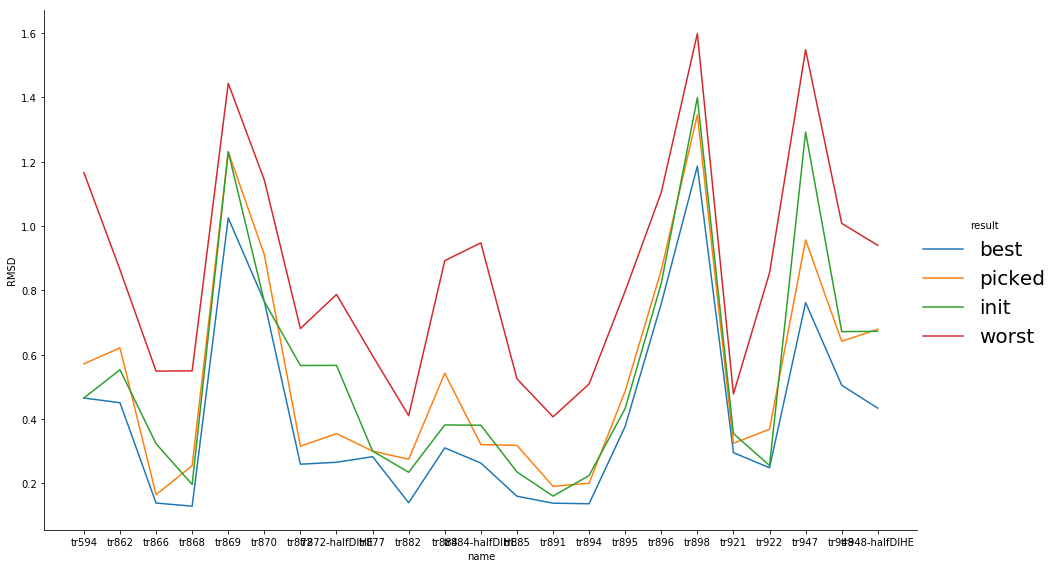

In [53]:
# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = [
    "biasQ",
    'Rw',
     'VTotal',
#     'RMSD', # test
#     'Qw',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "chosen"
DEGREE = 1

def pred_from_raw(a):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prob= clf.predict_proba(test_set)[:,1]
    return a.assign(prob=prob)

# data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
data = np.concatenate(raw_data.groupby('name').apply(my_transform, 
                                                     label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
train_y = data[:,-1]
train_set = data[:,:-1]

# clf = svm.SVC(probability=True)
# p = 0.01
# clf = LogisticRegression(random_state=27, class_weight={0:p, 1:(1-p)})
clf = LogisticRegression(random_state=27)
clf.fit(train_set, train_y)

filtered = filtered.reset_index(drop=True).groupby("name").apply(pred_from_raw).reset_index(drop=True)


picked_n = 1
best = raw_data_all_2.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
# if True:
picked_1 = filtered.groupby("name").apply(choose_top, col="prob"
                                        , n=1, ascending=False).reset_index(drop=True).query("chosen==True")

# if False:
picked_5 = filtered.groupby("name").apply(choose_top, col="prob"
                                            , n=5, ascending=False).reset_index(drop=True).query("chosen==True")
picked = picked_5.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
worst = filtered.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
init = raw_data_all_2.groupby("name").apply(choose_top, col="i"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
all_results = pd.concat([best.assign(result='best'), 
                         picked_1.assign(result='picked'), init.assign(result='init')
                        , worst.assign(result='worst')
                        ], sort=False)
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])
# picked.to_csv("/Users/weilu/Desktop/picked.csv

# sns.set(rc={'figure.figsize':(20,30)})
# plt.figure(figsize=(15,8))
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', 'RMSD').add_legend(fontsize=20)
# fg.set(ylim=(0, 10))

In [56]:
all_results.query("name == 'tr872-halfDIHE' or name == 'tr872'").query("result == 'picked_top1'")

,folder,i,RMSD,Rw,biasQ,bias,Qw,Step,Chain,Shake,...,Membrane,SSB,VTotal,pc,pc2,name,chosen,inrange,prob,result
13986,484,48400.0,0.315882,-12625.342314,0.675345,21.080226,0.654423,0.0,5.027838,0.0,...,0.0,0.0,-1138.137918,-0.849180,1.877866,tr872,True,True,0.357519,picked_top1
16566,912,41100.0,0.355024,-12638.637754,0.671949,21.523455,0.773383,0.0,4.560306,0.0,...,0.0,0.0,-1128.656025,0.212775,1.396896,tr872-halfDIHE,True,True,0.276979,picked_top1


In [55]:
all_results.query("name == 'tr948-halfDIHE' or name == 'tr948'").query("result == 'picked_top1'")

,folder,i,RMSD,Rw,biasQ,bias,Qw,Step,Chain,Shake,...,Membrane,SSB,VTotal,pc,pc2,name,chosen,inrange,prob,result
42499,810,30900.0,0.642138,-28698.131138,0.581505,35.027568,0.603420,0.0,9.830352,0.0,...,0.0,0.0,-2589.281395,-0.896550,2.553332,tr948,True,True,0.638205,picked_top1
46179,2343,33900.0,0.679436,-29090.797025,0.569006,37.151118,0.590497,0.0,8.691268,0.0,...,0.0,0.0,-2580.851263,1.535779,-0.682960,tr948-halfDIHE,True,True,0.324637,picked_top1


In [52]:
all_results.query("name == 'tr884-halfDIHE' or name == 'tr884'").query("result == 'picked_top1'")

,folder,i,RMSD,Rw,biasQ,bias,Qw,Step,Chain,Shake,...,Membrane,SSB,VTotal,pc,pc2,name,chosen,inrange,prob,result
23305,1448,44600.0,0.542798,-9418.042083,0.530488,44.088316,0.496556,0.0,3.516038,0.0,...,0.0,0.0,-924.112214,0.739004,-2.026302,tr884,True,True,0.245173,picked_top1
25653,1301,29900.0,0.320999,-9330.232483,0.615756,29.528697,0.700275,0.0,3.993937,0.0,...,0.0,0.0,-899.346439,-1.224431,-1.495779,tr884-halfDIHE,True,True,0.265686,picked_top1


In [54]:
all_results = pd.concat([picked_1.assign(result="picked_top1"), picked_5.assign(result='picked_top5'),
                         picked.assign(result='picked_best'),
                         best.assign(result='best'), 
                          init.assign(result='init'),
                         worst.assign(result='worst'), 
                        ], sort=False)

In [30]:
all_results.reset_index(drop=True).to_csv("/Users/weilu/Research/server/dec_2018/structure_selection_2/all_results.csv")

In [32]:
all_results = pd.read_csv("/Users/weilu/Research/server/dec_2018/structure_selection_2/all_results.csv", index_col=0)

In [62]:
all_results.query("result == 'picked_top5'").groupby("name").apply(pd.sort_values, "prob")

AttributeError: module 'pandas' has no attribute 'sort_values'

In [69]:
all_results.query("result == 'picked_top5'").sort_values(["name", "prob"], ascending=False)

,folder,i,RMSD,Rw,biasQ,bias,Qw,Step,Chain,Shake,...,Membrane,SSB,VTotal,pc,pc2,name,chosen,inrange,prob,result
46179,2343,33900.0,0.679436,-29090.797025,0.569006,37.151118,0.590497,0.0,8.691268,0.0,...,0.0,0.0,-2580.851263,1.535779,-0.682960,tr948-halfDIHE,True,True,0.324637,picked_top5
46095,2259,25500.0,0.685912,-28563.342610,0.574794,36.159959,0.584476,0.0,10.473595,0.0,...,0.0,0.0,-2575.861825,2.225680,0.153428,tr948-halfDIHE,True,True,0.277318,picked_top5
45093,1058,5600.0,0.614140,-28463.547489,0.571656,36.695699,0.633013,0.0,7.506891,0.0,...,0.0,0.0,-2578.116063,0.704460,-0.745613,tr948-halfDIHE,True,True,0.251004,picked_top5
44653,617,11600.0,0.530739,-28601.483932,0.568418,37.252623,0.635398,0.0,11.437000,0.0,...,0.0,0.0,-2579.379165,0.932754,0.857359,tr948-halfDIHE,True,True,0.245794,picked_top5
46189,2353,34900.0,0.677295,-28758.016932,0.575408,36.055693,0.596811,0.0,10.026178,0.0,...,0.0,0.0,-2565.811382,2.009119,-1.507732,tr948-halfDIHE,True,True,0.236490,picked_top5
42499,810,30900.0,0.642138,-28698.131138,0.581505,35.027568,0.603420,0.0,9.830352,0.0,...,0.0,0.0,-2589.281395,-0.896550,2.553332,tr948,True,True,0.638205,picked_top5
42677,988,48700.0,0.556396,-28450.977135,0.581825,34.974074,0.609090,0.0,9.318828,0.0,...,0.0,0.0,-2589.462466,-0.319427,2.296344,tr948,True,True,0.603070,picked_top5
42551,862,36100.0,0.660701,-28421.082123,0.574724,36.171940,0.572905,0.0,9.357762,0.0,...,0.0,0.0,-2589.151368,-0.797111,2.190730,tr948,True,True,0.503406,picked_top5
42566,877,37600.0,0.645414,-28593.010397,0.577859,35.640522,0.581267,0.0,9.385711,0.0,...,0.0,0.0,-2580.545925,-0.431302,2.888052,tr948,True,True,0.489552,picked_top5
42662,973,47200.0,0.562767,-28345.005686,0.573871,36.317265,0.612495,0.0,9.712646,0.0,...,0.0,0.0,-2586.339493,-0.358514,2.007456,tr948,True,True,0.451314,picked_top5


In [41]:
for i, line in all_results.query("result == 'picked_top5'").reset_index(drop=True).iterrows():
    print(i, line["name"], line["folder"])
    os.system("")

0 tr594 2028
1 tr594 2080
2 tr594 2252
3 tr594 2257
4 tr594 2284
5 tr862 711
6 tr862 714
7 tr862 716
8 tr862 840
9 tr862 881
10 tr866 127
11 tr866 273
12 tr866 296
13 tr866 391
14 tr866 436
15 tr868 278
16 tr868 772
17 tr868 774
18 tr868 949
19 tr868 1009
20 tr869 0
21 tr869 501
22 tr869 1002
23 tr869 1503
24 tr869 2004
25 tr870 129
26 tr870 186
27 tr870 220
28 tr870 293
29 tr870 499
30 tr872 130
31 tr872 403
32 tr872 480
33 tr872 484
34 tr872 1597
35 tr872-halfDIHE 0
36 tr872-halfDIHE 501
37 tr872-halfDIHE 912
38 tr872-halfDIHE 940
39 tr872-halfDIHE 1507
40 tr877 0
41 tr877 501
42 tr877 1002
43 tr877 1503
44 tr877 2004
45 tr882 0
46 tr882 501
47 tr882 1002
48 tr882 1585
49 tr882 1965
50 tr884 492
51 tr884 497
52 tr884 1447
53 tr884 1448
54 tr884 1493
55 tr884-halfDIHE 1192
56 tr884-halfDIHE 1194
57 tr884-halfDIHE 1301
58 tr884-halfDIHE 1306
59 tr884-halfDIHE 2335
60 tr885 1065
61 tr885 1091
62 tr885 1111
63 tr885 1128
64 tr885 1267
65 tr891 86
66 tr891 561
67 tr891 570
68 tr891 611
69

In [23]:
all_results = pd.concat([picked_1.assign(result="picked_top1"), picked.assign(result='picked_top5'),
                         best.assign(result='best'), 
                          init.assign(result='init'),
                         worst.assign(result='worst'), 
                        ], sort=False)

In [25]:
picked.shape

(20, 30)

In [32]:
all_results.reindex(columns=my_reorder(all_results.columns, ["name", "RMSD", "result"])) .reset_index(drop=True).to_csv("/Users/weilu/Desktop/selection_result.csv")

In [28]:
def my_reorder(a, first):
    # move first to the top. and keep the rest
    new_order = first.copy()
    for col in a:
        if col not in first:
            new_order.append(col)
    return new_order

In [31]:
all_results.reindex(columns=my_reorder(all_results.columns, ["name", "RMSD", "result"])) 

,name,RMSD,result,folder,i,Rw,biasQ,bias,Qw,Step,...,Frag_Mem,Vec_FM,Membrane,SSB,VTotal,pc,pc2,chosen,inrange,prob
1917,tr594,5.71845,picked_top1,2028,2400.0,-9655.812091,0.562631,38.258352,0.397447,0.0,...,-542.733446,0.0,0.0,0.0,-976.169211,1.783749,-0.897284,True,True,0.336318
3098,tr862,6.21427,picked_top1,716,21500.0,-14017.862442,0.795115,8.395546,0.461948,0.0,...,-860.309802,0.0,0.0,0.0,-1467.578457,-1.316991,-2.854982,True,True,0.184471
5040,tr866,1.65094,picked_top1,436,43600.0,-17053.726578,0.628532,27.597682,0.834830,0.0,...,-730.772207,0.0,0.0,0.0,-1442.122133,-0.087063,3.699315,True,True,0.220490
7964,tr868,2.55439,picked_top1,1009,700.0,-19002.022160,0.515777,46.894413,0.759775,0.0,...,-1184.431369,0.0,0.0,0.0,-1896.962431,0.139004,-0.381850,True,True,0.419466
9181,tr869,12.30950,picked_top1,0,0.0,-17101.278236,0.327521,90.445532,0.340709,0.0,...,-745.292489,0.0,0.0,0.0,-1364.887693,-0.000178,-0.048953,True,True,0.287940
11347,tr870,8.98989,picked_top1,27,2700.0,-18766.397302,0.366368,80.297996,0.325325,0.0,...,-919.447094,0.0,0.0,0.0,-1663.622985,-1.937195,-0.884915,True,True,0.021734
13892,tr872,3.88397,picked_top1,130,13000.0,-12597.510264,0.673965,21.259789,0.654242,0.0,...,-546.317159,0.0,0.0,0.0,-1131.645842,0.635999,-1.004592,True,True,0.232302
15145,tr877,3.00711,picked_top1,0,0.0,-24114.108027,0.568868,37.174966,0.648838,0.0,...,-821.245402,0.0,0.0,0.0,-1699.528374,-0.055574,-0.014200,True,True,0.773073
18607,tr882,2.75337,picked_top1,1585,8200.0,-12227.807526,0.648724,24.679000,0.790488,0.0,...,-630.005603,0.0,0.0,0.0,-1123.346564,-0.326972,0.008144,True,True,0.257559
20532,tr884,5.42798,picked_top1,1448,44600.0,-9418.042083,0.530488,44.088316,0.496556,0.0,...,-492.254269,0.0,0.0,0.0,-924.112214,0.739004,-2.026302,True,True,0.231153


In [ ]:
picked

In [19]:
count = 0
total = 0
for name in folder_list:
    init_tmp = init.query(f"name == '{name}'")["RMSD"].iloc[0]
    picked_tmp = picked.query(f"name == '{name}'")["RMSD"].iloc[0]
    improved = picked_tmp < init_tmp
    print(name, init_tmp, picked_tmp, round(init_tmp - picked_tmp, 3), improved)
    total += init_tmp - picked_tmp
    count += improved
print("improved: ", count, len(folder_list), total)

tr898 13.9965 13.4609 0.536 True
tr869 12.3095 12.3095 0.0 False
tr947 12.9222 8.10622 4.816 True
tr894 2.24606 1.6856900000000001 0.56 True
tr882 2.34977 2.28804 0.062 True
tr594 4.65665 5.71845 -1.062 False
tr862 5.53469 5.91362 -0.379 False
tr877 3.00711 3.00711 0.0 False
tr872 5.66699 3.38775 2.279 True
tr885 2.35937 2.72348 -0.364 False
tr866 3.23637 1.52312 1.713 True
tr868 1.97032 1.94233 0.028 True
tr884 3.81972 4.60271 -0.783 False
tr895 4.333819999999999 4.87177 -0.538 False
tr896 8.22359 8.01121 0.212 True
tr870 7.65488 8.81563 -1.161 False
tr921 3.55243 3.17155 0.381 True
tr922 2.55776 3.28628 -0.729 False
tr891 1.60893 1.91208 -0.303 False
tr948 6.721260000000001 5.56396 1.157 True
improved:  10 20 6.42652


In [26]:
count = 0
total = 0
for name in folder_list:
    init_tmp = init.query(f"name == '{name}'")["RMSD"].iloc[0]
    picked_tmp = picked_1.query(f"name == '{name}'")["RMSD"].iloc[0]
    improved = picked_tmp < init_tmp
    print(name, init_tmp, picked_tmp, round(init_tmp - picked_tmp, 3), improved)
    total += init_tmp - picked_tmp
    count += improved
print("improved: ", count, len(folder_list), total)

tr898 13.9965 13.4609 0.536 True
tr869 12.3095 12.3095 0.0 False
tr947 12.9222 9.56921 3.353 True
tr894 2.24606 2.00769 0.238 True
tr882 2.34977 2.75337 -0.404 False
tr594 4.65665 5.71845 -1.062 False
tr862 5.53469 6.21427 -0.68 False
tr877 3.00711 3.00711 0.0 False
tr872 5.66699 3.8839699999999997 1.783 True
tr885 2.35937 3.1840200000000003 -0.825 False
tr866 3.23637 1.65094 1.585 True
tr868 1.97032 2.55439 -0.584 False
tr884 3.81972 5.427980000000001 -1.608 False
tr895 4.333819999999999 4.87177 -0.538 False
tr896 8.22359 8.629610000000001 -0.406 False
tr870 7.65488 8.989889999999999 -1.335 False
tr921 3.55243 3.24877 0.304 True
tr922 2.55776 3.6866800000000004 -1.129 False
tr891 1.60893 1.91208 -0.303 False
tr948 6.721260000000001 6.42138 0.3 True
improved:  7 20 -0.7740600000000017


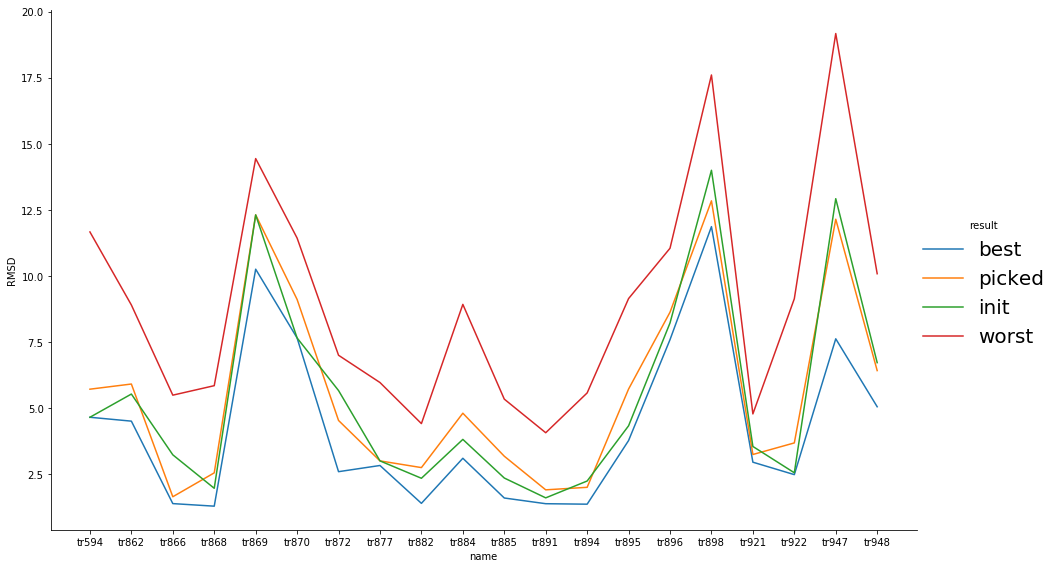

In [181]:
filtered = a
# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = [
    "biasQ",
    'Rw',
     'VTotal',
#     'RMSD', # test
#     'Qw',
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "chosen"
DEGREE = 1

def pred_from_raw(a):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prob= clf.predict_proba(test_set)[:,1]
    return a.assign(prob=prob)

# data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
data = np.concatenate(raw_data.groupby('name').apply(my_transform, 
                                                     label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
train_y = data[:,-1]
train_set = data[:,:-1]

# clf = svm.SVC(probability=True)
# p = 0.01
# clf = LogisticRegression(random_state=27, class_weight={0:p, 1:(1-p)})
clf = LogisticRegression(random_state=27)
clf.fit(train_set, train_y)

filtered = filtered.reset_index(drop=True).groupby("name").apply(pred_from_raw).reset_index(drop=True)


picked_n = 1
best = raw_data_all_2.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
if True:
    picked = filtered.groupby("name").apply(choose_top, col="prob"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")

if False:
    picked = filtered.groupby("name").apply(choose_top, col="prob"
                                                , n=5, ascending=False).reset_index(drop=True).query("chosen==True")
    picked = picked.groupby("name").apply(choose_top, col="RMSD"
                                                , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
worst = filtered.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
init = raw_data_all_2.groupby("name").apply(choose_top, col="i"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
all_results = pd.concat([best.assign(result='best'), 
                         picked.assign(result='picked'), init.assign(result='init')
                        , worst.assign(result='worst')
                        ], sort=False)
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])
# picked.to_csv("/Users/weilu/Desktop/picked.csv

# sns.set(rc={'figure.figsize':(20,30)})
# plt.figure(figsize=(15,8))
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', 'RMSD').add_legend(fontsize=20)
# fg.set(ylim=(0, 10))

In [182]:
count = 0
total = 0
for name in folder_list:
    init_tmp = init.query(f"name == '{name}'")["RMSD"].iloc[0]
    picked_tmp = picked.query(f"name == '{name}'")["RMSD"].iloc[0]
    improved = picked_tmp < init_tmp
    print(name, init_tmp, picked_tmp, round(init_tmp - picked_tmp, 3), improved)
    total += init_tmp - picked_tmp
    count += improved
print("improved: ", count, len(folder_list), total)

tr898 13.9965 12.8408 1.156 True
tr869 12.3095 12.3095 0.0 False
tr947 12.9222 12.1452 0.777 True
tr894 2.24606 2.00769 0.238 True
tr882 2.34977 2.75337 -0.404 False
tr594 4.65665 5.71845 -1.062 False
tr862 5.53469 5.91362 -0.379 False
tr877 3.00711 3.00711 0.0 False
tr872 5.66699 4.53573 1.131 True
tr885 2.35937 3.1840200000000003 -0.825 False
tr866 3.23637 1.65094 1.585 True
tr868 1.97032 2.55439 -0.584 False
tr884 3.81972 4.81 -0.99 False
tr895 4.333819999999999 5.72387 -1.39 False
tr896 8.22359 8.629610000000001 -0.406 False
tr870 7.65488 9.11107 -1.456 False
tr921 3.55243 3.24877 0.304 True
tr922 2.55776 3.6866800000000004 -1.129 False
tr891 1.60893 1.91208 -0.303 False
tr948 6.721260000000001 6.42138 0.3 True
improved:  7 20 -3.436360000000002


In [339]:
all_results.query("name == 'tr594'")

,folder,i,RMSD,Rw,biasQ,bias,Qw,Step,Chain,Shake,...,SSB,VTotal,pc,pc2,name,chosen,result,pc_center,inrange,prob
0,0,0.0,4.65665,-10838.987781,0.590522,33.534424,0.464193,0.0,14.571923,0.0,...,0.0,-940.887277,-0.086922,-0.059985,tr594,True,best,NaN,NaN,NaN
0,0,0.0,4.65665,-10838.987781,0.590522,33.534424,0.464193,0.0,14.571923,0.0,...,0.0,-940.887277,-0.086922,-0.059985,tr594,True,picked,0.703,True,0.042606
0,0,0.0,4.65665,-10838.987781,0.590522,33.534424,0.464193,0.0,14.571923,0.0,...,0.0,-940.887277,-0.086922,-0.059985,tr594,True,init,NaN,NaN,NaN
1020,2380,37600.0,11.55900,-8163.823349,0.491720,51.669743,0.349195,0.0,4.380186,0.0,...,0.0,-960.110987,1.421570,-0.122716,tr594,True,worst,0.703,True,0.003102


In [35]:
clf.coef_

array([[ 0.24185815, -0.37308731, -0.43718463]])

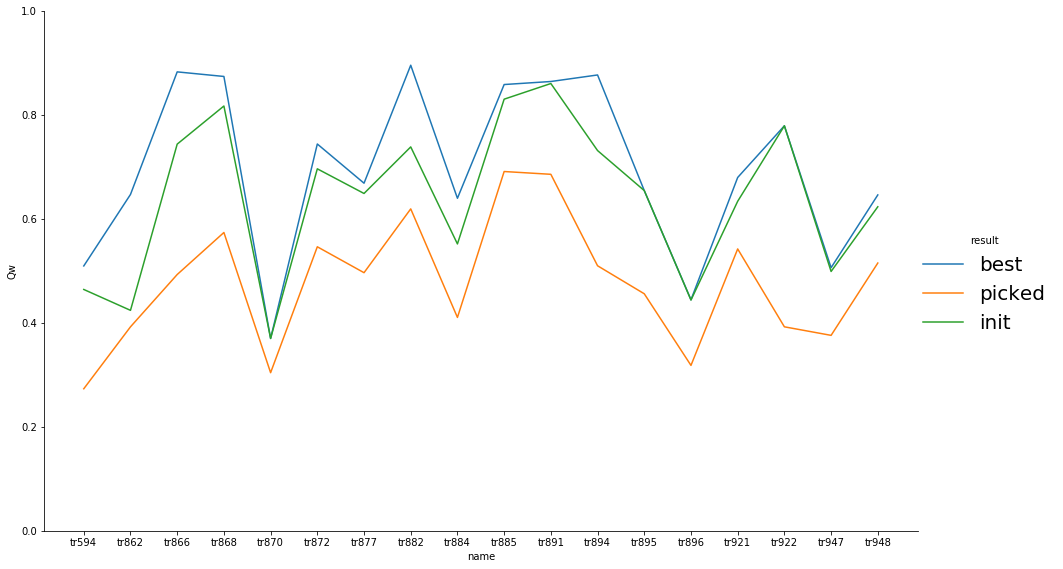

In [221]:

Plot_Metric = "Qw"
if Plot_Metric:
    isAscending = False
else:
    isAscending = True

picked_n = 1
best = raw_data_all_2.groupby("name").apply(choose_top, col=Plot_Metric
                                            , n=1, ascending=isAscending).reset_index(drop=True).query("chosen==True")
picked = filtered.groupby("name").apply(choose_top, col="prob"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
worst = filtered.groupby("name").apply(choose_top, col=Plot_Metric
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
init = raw_data_all_2.groupby("name").apply(choose_top, col="i"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
all_results = pd.concat([best.assign(result='best'), 
                         picked.assign(result='picked'), init.assign(result='init')
#                         , worst.assign(result='worst')
                        ], sort=False)
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])
# picked.to_csv("/Users/weilu/Desktop/picked.csv

# sns.set(rc={'figure.figsize':(20,30)})
# plt.figure(figsize=(15,8))
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', Plot_Metric).add_legend(fontsize=20)
fg.set(ylim=(0, 1))

In [170]:
picked["init_RMSD"] = init["RMSD"].values
picked["diff_RMSD"] = init["RMSD"].values - picked["RMSD"].values
out = picked[["name", "RMSD", "init_RMSD", "diff_RMSD", "folder"]].reset_index(drop=True)

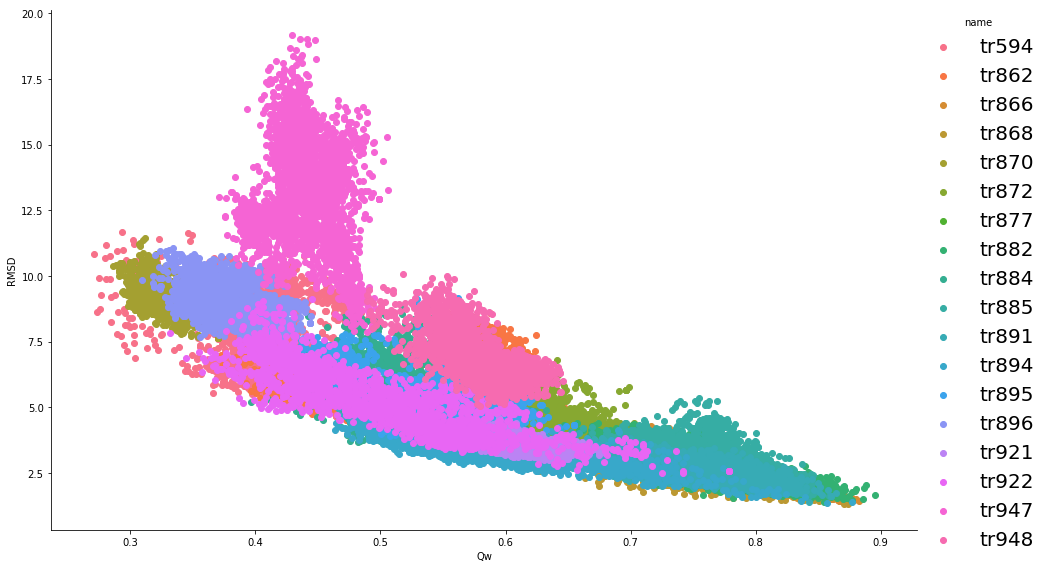

In [206]:
fg = sns.FacetGrid(data=filtered, hue='name', height=8, aspect=1.63)
fg.map(plt.scatter, 'Qw', 'RMSD').add_legend(fontsize=20)

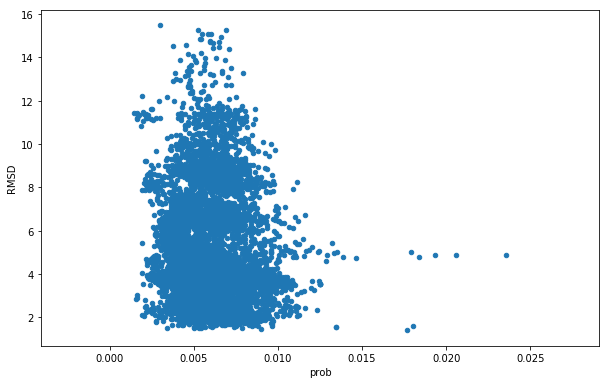

In [35]:
filtered.plot.scatter("prob", "RMSD")

In [25]:
out

,name,RMSD,init_RMSD,diff_RMSD,folder
0,tr894,1.36968,2.24606,0.87638,980


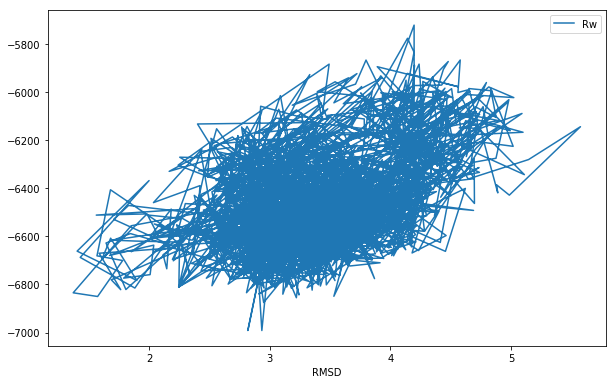

In [13]:
raw_data_all_2.plot("RMSD", "Rw")

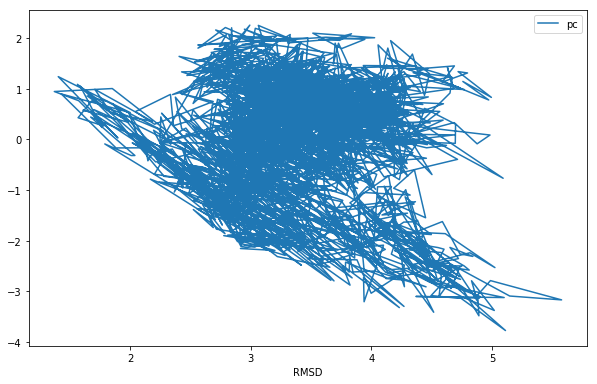

In [14]:
raw_data_all_2.plot("RMSD", "pc")

In [15]:
out

,name,RMSD,init_RMSD,diff_RMSD,folder
0,tr894,1.36968,2.24606,0.87638,980


In [16]:
out

,name,RMSD,init_RMSD,diff_RMSD,folder
0,tr894,1.36968,2.24606,0.87638,980


In [70]:
all_results

,folder,i,RMSD,Rw,biasQ,bias,Step,Chain,Shake,Chi,...,SSB,VTotal,pc,pc2,name,chosen,result,pc_center,inrange,prob
980,980,47900.0,1.36968,-6834.949362,0.645772,25.095468,0,3.685220,0.0,0.588609,...,0.0,-656.184416,0.944122,-0.804111,tr894,True,best,NaN,NaN,NaN
981,981,48000.0,1.57229,-6850.297788,0.673878,21.271087,0,4.750551,0.0,0.512601,...,0.0,-659.909501,0.762314,-0.531746,tr894,True,picked,2.03,True,0.523816
0,0,0.0,2.24606,-6810.073249,0.556208,39.390241,0,5.546380,0.0,1.160888,...,0.0,-668.558313,-0.065067,-0.283718,tr894,True,init,NaN,NaN,NaN


In [13]:
# out.to_csv("/Users/weilu/Desktop/picked_3.csv")

In [26]:
clf.coef_

array([[ 0.31865771, -0.24574338, -0.00429271, -0.15621297,  0.12086065,
         0.03529636,  0.05114406,  0.06779384,  0.23049113, -0.0941187 ]])

In [14]:
clf.coef_

array([[ 0.20157408, -0.69485223,  0.04456798]])

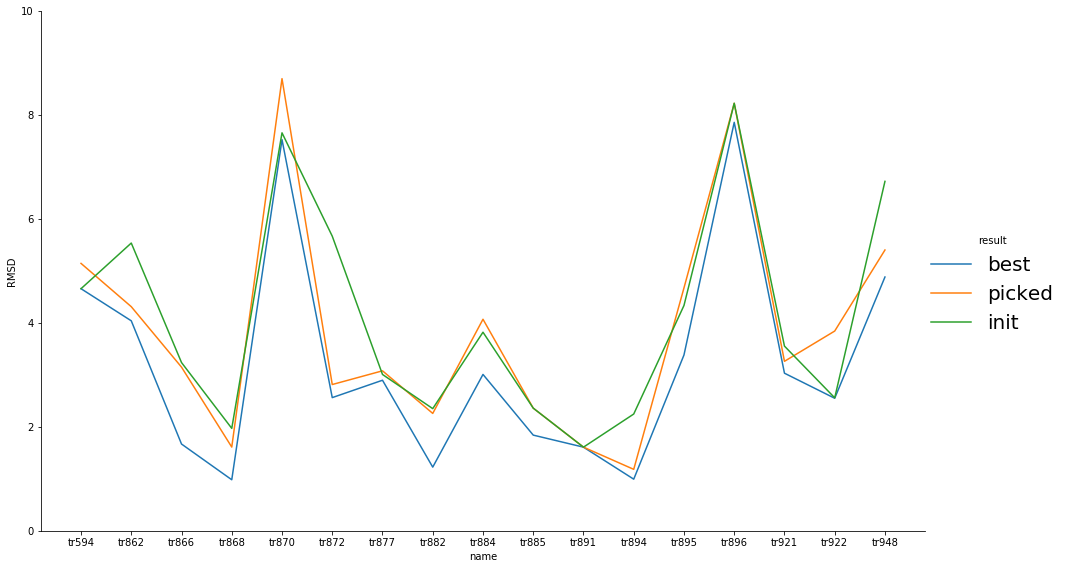

In [15]:
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', 'RMSD').add_legend(fontsize=20)
fg.set(ylim=(0, 10))

In [16]:
filtered["name"].unique().shape

(17,)

In [17]:
picked[["RMSD", "name"]]

,RMSD,name
0,5.14331,tr594
1136,4.31091,tr862
1890,3.14792,tr866
2586,1.61058,tr868
3123,8.69691,tr870
3576,2.81351,tr872
4796,3.07719,tr877
5446,2.25775,tr882
6372,4.06919,tr884
6989,2.35937,tr885


In [18]:
# picked.to_csv("/Users/weilu/Desktop/picked_2.csv")

In [19]:
name ="tr894"
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB","VTotal"]

# you probably want to change the location below
#     location = f"/Users/weilu/Research/server/sep_2018/03_week/02_week/{name}/"
location = f"/Users/weilu/Research/server/nov_2018/structure_selection/{name}/"
RMSD = pd.read_table(location+"rmsd-angstrom.xvg", names=["i", "RMSD"], sep="\s+")
bias = pd.read_table(location+"bias.log", names=["i", "biasQ", "bias"], sep="\s+").drop("i", axis=1)
awsem = pd.read_table(location+"awsem.log", names=name_list)
rw = pd.read_table(location+"rwplusScore.txt", names=["i", "Rw"], sep="\s+").drop("i", axis=1)
# pc location
#     location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
#     location = f"/Users/weilu/Research/server/oct_2018/01_week/{name}/"
pc = pd.read_table(location+"pcarmsd_scaled.txt", names=["i", "pc", "pc2"], sep="\s+", comment="#").drop("i", axis=1)
raw_data = pd.concat([RMSD, rw, bias, awsem, pc], axis=1)
raw_data.assign(name=name).reset_index().rename(columns={"index":"folder"})

,folder,i,RMSD,Rw,biasQ,bias,Step,Chain,Shake,Chi,...,Helix,AMH_Go,Frag_Mem,Vec_FM,Membrane,SSB,VTotal,pc,pc2,name
0,0,0.0,2.24606,-6810.073249,0.556208,39.390241,0,5.546380,0.0,1.160888,...,-11.494550,0.0,-330.532789,0.0,0.0,0.0,-668.558313,-0.065067,-0.283718,tr894
1,1,100.0,3.23173,-6286.940968,0.551209,40.282725,0,2.470745,0.0,0.544233,...,-12.663186,0.0,-332.365779,0.0,0.0,0.0,-661.611254,-2.030413,-1.872569,tr894
2,2,200.0,3.21661,-6289.430903,0.497013,50.599184,0,4.764399,0.0,0.562483,...,-13.188086,0.0,-332.765589,0.0,0.0,0.0,-658.149297,-2.028462,-1.644785,tr894
3,3,300.0,3.15813,-6190.501191,0.528574,44.448412,0,2.255989,0.0,0.468350,...,-13.341891,0.0,-333.111932,0.0,0.0,0.0,-662.850984,-1.765059,-1.880311,tr894
4,4,400.0,3.48106,-6070.736394,0.507673,48.477271,0,4.563115,0.0,0.358890,...,-13.054297,0.0,-332.096669,0.0,0.0,0.0,-655.505067,-2.050421,-0.862438,tr894
5,5,500.0,3.21603,-6207.393138,0.507665,48.478663,0,3.079867,0.0,0.562905,...,-12.983445,0.0,-334.065069,0.0,0.0,0.0,-654.514531,-2.024328,-0.505672,tr894
6,6,600.0,3.26742,-6270.166177,0.515849,46.880384,0,3.598324,0.0,0.689476,...,-12.473662,0.0,-329.046856,0.0,0.0,0.0,-661.071468,-2.225011,-1.368251,tr894
7,7,700.0,3.45545,-6275.141716,0.521223,45.845485,0,3.142972,0.0,0.471721,...,-12.879093,0.0,-330.526926,0.0,0.0,0.0,-660.649964,-1.917079,-0.934712,tr894
8,8,800.0,2.84899,-6353.542762,0.521744,45.745735,0,4.776124,0.0,0.537145,...,-12.874610,0.0,-330.107068,0.0,0.0,0.0,-666.482035,-1.836351,-1.092572,tr894
9,9,900.0,3.43413,-6114.807297,0.567139,37.473775,0,3.616298,0.0,0.553106,...,-13.392355,0.0,-332.670193,0.0,0.0,0.0,-664.643019,-1.984028,-1.763320,tr894
